# Task 5 - Model Training and Tracking

This notebook trains multiple classification models, tunes hyperparameters, and tracks experiments with MLflow.

**Objectives:**
- Split data into train/test sets.
- Train 4 models: Logistic Regression, Decision Tree, Random Forest, Gradient Boosting.
- Tune hyperparameters with GridSearchCV.
- Evaluate: Accuracy, Precision, Recall, F1, ROC-AUC.
- Track all experiments with MLflow.
- Register the best model in MLflow Model Registry.
- Compute WoE/IV for key features using the real target.

## 1. Setup and Imports

In [ ]:
import sys
from pathlib import Path

# Add src to path
PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT / "src"))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow

from train import (
    load_modeling_data,
    split_data,
    train_all_models,
    get_best_model,
    register_best_model,
    evaluate_model,
    plot_confusion_matrix,
    plot_roc_curve,
)
from feature_engineering import compute_woe_iv

# Plot settings
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

print("Imports successful.")

Imports successful.


## 2. Load Modeling Data

In [ ]:
df, X, y = load_modeling_data()

print(f"Full dataset shape: {df.shape}")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns ({len(X.columns)}):")
print(X.columns.tolist())

Full dataset shape: (3742, 29)
Features shape: (3742, 26)
Target shape: (3742,)

Feature columns (26):
['txn_count', 'total_amount', 'avg_amount', 'std_amount', 'min_amount', 'max_amount', 'total_value', 'avg_value', 'avg_txn_hour', 'std_txn_hour', 'weekend_txn_ratio', 'net_amount', 'n_credits', 'n_debits', 'productcategory_financial_services_ratio', 'productcategory_airtime_ratio', 'productcategory_utility_bill_ratio', 'channelid_channelid_3_ratio', 'channelid_channelid_2_ratio', 'channelid_channelid_5_ratio', 'providerid_providerid_4_ratio', 'providerid_providerid_6_ratio', 'providerid_providerid_5_ratio', 'recency_days', 'frequency', 'monetary']


In [ ]:
# Target distribution
print("Target distribution:")
print(y.value_counts())
print(f"\nHigh-risk rate: {y.mean() * 100:.2f}%")

Target distribution:
is_high_risk
0    2316
1    1426
Name: count, dtype: int64

High-risk rate: 38.11%


**Observation**: The target is reasonably balanced (~38% high-risk), which is good for classification.

## 3. Split Data into Train/Test Sets

In [ ]:
X_train, X_test, y_train, y_test = split_data(X, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTrain target distribution:")
print(y_train.value_counts())
print(f"\nTest target distribution:")
print(y_test.value_counts())

Training set: 2993 samples
Test set: 749 samples

Train target distribution:
is_high_risk
0    1852
1    1141
Name: count, dtype: int64

Test target distribution:
is_high_risk
0    464
1    285
Name: count, dtype: int64


**Observation**: Stratified split ensures similar class proportions in train and test sets.

## 4. Train All Models with MLflow Tracking

We will train 4 models:
1. **Logistic Regression** - baseline, interpretable
2. **Decision Tree** - simple nonlinear model
3. **Random Forest** - ensemble of trees
4. **Gradient Boosting** - boosting-based ensemble

Each model will be:
- Tuned with GridSearchCV (5-fold CV, optimizing ROC-AUC).
- Evaluated on the test set.
- Logged to MLflow (params, metrics, artifacts, model).

In [ ]:
# Set MLflow tracking URI (local file-based)
mlflow.set_tracking_uri("file:" + str(PROJECT_ROOT / "mlruns"))

print(f"MLflow tracking URI: {mlflow.get_tracking_uri()}")

MLflow tracking URI: file:/Users/macbookpro/Documents/Credit-Risk-Probability-Model/mlruns


In [ ]:
# Train all models (this may take a few minutes)
results = train_all_models(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    experiment_name="Credit_Risk_Models"
)

/Users/macbookpro/Documents/Credit-Risk-Probability-Model/.venv/lib/python3.14/site-packages/mlflow/tracking/_tracking_service/utils.py:177: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance.
  return FileStore(store_uri, store_uri)
2025/12/10 22:20:36 INFO mlflow.tracking.fluent: Experiment with name 'Credit_Risk_Models' does not exist. Creating a new experiment.



Training: LogisticRegression


/Users/macbookpro/Documents/Credit-Risk-Probability-Model/.venv/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/macbookpro/Documents/Credit-Risk-Probability-Model/.venv/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/macbookpro/Documents/Credit-Risk-Probability-Model/.venv/lib/python3.14/site-packages/sklearn/linea

/Users/macbookpro/Documents/Credit-Risk-Probability-Model/.venv/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/macbookpro/Documents/Credit-Risk-Probability-Model/.venv/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/macbookpro/Documents/Credit-Risk-Probability-Model/.venv/lib/python3.14/site-packages/sklearn/linea

[LogisticRegression] Run ID: fc5304ac7949407cb901492227ef295a
  Best params: {'classifier__C': 10.0, 'classifier__class_weight': None, 'classifier__penalty': 'l2'}
  Metrics: {'accuracy': 0.9933244325767691, 'precision': 0.9964539007092199, 'recall': 0.9859649122807017, 'f1': 0.9911816578483245, 'roc_auc': 0.9998109497882637}

Training: DecisionTree


2025/12/10 22:20:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


[DecisionTree] Run ID: a367f136678648aeb9f8f57d35ca5c1e
  Best params: {'classifier__class_weight': None, 'classifier__max_depth': 3, 'classifier__min_samples_split': 2}
  Metrics: {'accuracy': 0.9933244325767691, 'precision': 0.9861111111111112, 'recall': 0.9964912280701754, 'f1': 0.9912739965095986, 'roc_auc': 0.9959618874773141}

Training: RandomForest


/Users/macbookpro/Documents/Credit-Risk-Probability-Model/.venv/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/macbookpro/Documents/Credit-Risk-Probability-Model/.venv/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/macbookpro/Documents/Credit-Risk-Probability-Model/.venv/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the curre

2025/12/10 22:20:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


[RandomForest] Run ID: fff0927fc50042afa0295544ece28575
  Best params: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 50}
  Metrics: {'accuracy': 0.9959946595460614, 'precision': 0.9964788732394366, 'recall': 0.9929824561403509, 'f1': 0.9947275922671354, 'roc_auc': 0.9999016938898972}

Training: GradientBoosting


2025/12/10 22:20:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


[GradientBoosting] Run ID: f42196e4e70a42bb86e9c12f4e7ed656
  Best params: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 200}
  Metrics: {'accuracy': 0.9933244325767691, 'precision': 0.9929577464788732, 'recall': 0.9894736842105263, 'f1': 0.9912126537785588, 'roc_auc': 0.9988430127041743}


## 5. Compare Model Results

In [ ]:
# Create comparison DataFrame
comparison_data = []
for model_name, data in results.items():
    row = {"Model": model_name, **data["metrics"]}
    comparison_data.append(row)

df_comparison = pd.DataFrame(comparison_data)
df_comparison = df_comparison.sort_values("roc_auc", ascending=False).reset_index(drop=True)

print("Model Comparison (sorted by ROC-AUC):")
df_comparison

Model Comparison (sorted by ROC-AUC):


,Model,accuracy,precision,recall,f1,roc_auc
0,RandomForest,0.995995,0.996479,0.992982,0.994728,0.999902
1,LogisticRegression,0.993324,0.996454,0.985965,0.991182,0.999811
2,GradientBoosting,0.993324,0.992958,0.989474,0.991213,0.998843
3,DecisionTree,0.993324,0.986111,0.996491,0.991274,0.995962


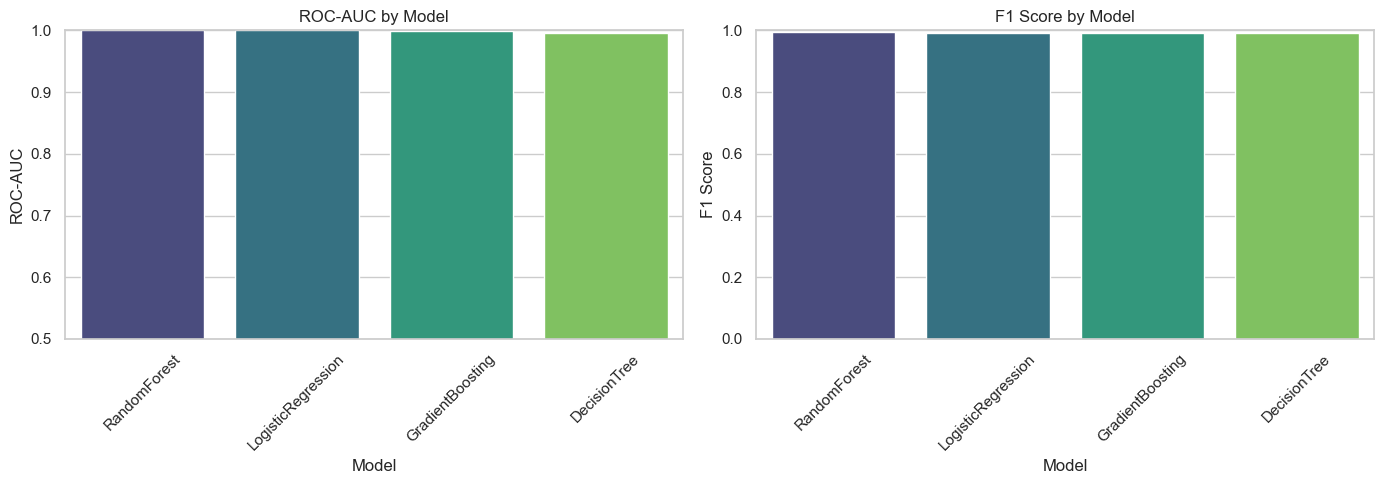

In [ ]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC-AUC comparison
sns.barplot(x="Model", y="roc_auc", data=df_comparison, ax=axes[0], palette="viridis", hue="Model", legend=False)
axes[0].set_title("ROC-AUC by Model")
axes[0].set_ylim(0.5, 1.0)
axes[0].set_ylabel("ROC-AUC")
axes[0].tick_params(axis="x", rotation=45)

# F1 comparison
sns.barplot(x="Model", y="f1", data=df_comparison, ax=axes[1], palette="viridis", hue="Model", legend=False)
axes[1].set_title("F1 Score by Model")
axes[1].set_ylim(0, 1.0)
axes[1].set_ylabel("F1 Score")
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

## 6. Identify and Register Best Model

In [ ]:
# Identify best model by ROC-AUC
best_model_name = get_best_model(results, metric="roc_auc")
best_metrics = results[best_model_name]["metrics"]

print(f"Best Model: {best_model_name}")
print(f"\nMetrics:")
for metric, value in best_metrics.items():
    print(f"  {metric}: {value:.4f}")

Best Model: RandomForest

Metrics:
  accuracy: 0.9960
  precision: 0.9965
  recall: 0.9930
  f1: 0.9947
  roc_auc: 0.9999


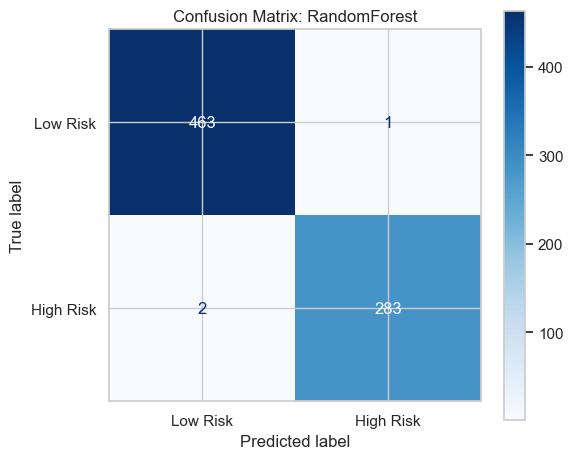

In [ ]:
# Show confusion matrix for best model
best_model = results[best_model_name]["model"]
fig = plot_confusion_matrix(best_model, X_test, y_test, best_model_name)
plt.show()

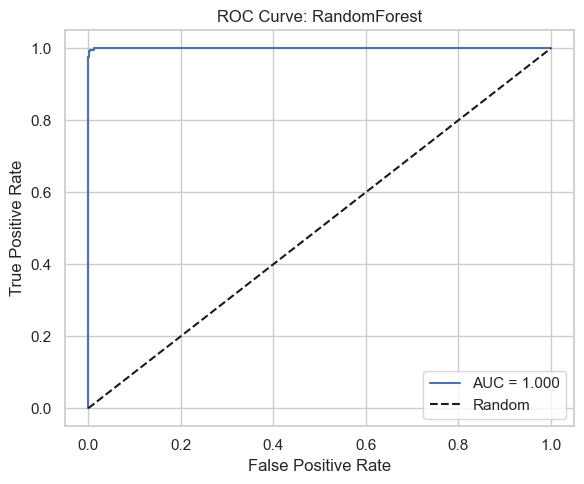

In [ ]:
# Show ROC curve for best model
fig = plot_roc_curve(best_model, X_test, y_test, best_model_name)
plt.show()

In [ ]:
# Register best model in MLflow Model Registry
try:
    version = register_best_model(results, best_model_name, registry_name="CreditRiskModel")
    print(f"\nModel registered successfully as version {version}")
except Exception as e:
    print(f"Note: Model registration requires MLflow server. Error: {e}")
    print("The model is still logged and can be loaded from the run artifacts.")

/Users/macbookpro/Documents/Credit-Risk-Probability-Model/.venv/lib/python3.14/site-packages/mlflow/tracking/_model_registry/utils.py:215: FutureWarning: The filesystem model registry backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance.
  return FileStore(store_uri)
Successfully registered model 'CreditRiskModel'.
2025/12/10 22:21:00 WARNING mlflow.tracking._model_registry.fluent: Run with id fff0927fc50042afa0295544ece28575 has no artifacts at artifact path 'model', registering model based on models:/m-cb4630b4880e417581d3905398e4b789 instead


Registered model 'CreditRiskModel' version 1

Model registered successfully as version 1


Created version '1' of model 'CreditRiskModel'.


## 7. WoE and IV Analysis (Real Target)

Now that we have the real `is_high_risk` target, we can compute Weight of Evidence (WoE) and Information Value (IV) for key features.

In [ ]:
# Prepare data for WoE analysis
df_woe = df.copy()

# Features to analyze
features_for_woe = ["txn_count", "recency_days", "total_amount", "frequency", "monetary"]

# Compute WoE/IV for each feature
woe_results = {}
iv_summary = []

for feature in features_for_woe:
    if feature in df_woe.columns:
        woe_df = compute_woe_iv(df_woe, feature, "is_high_risk", bins=5)
        woe_results[feature] = woe_df
        total_iv = woe_df["total_iv"].iloc[0]
        iv_summary.append({"feature": feature, "IV": total_iv})

df_iv = pd.DataFrame(iv_summary).sort_values("IV", ascending=False)
print("Information Value (IV) Summary:")
print("IV Interpretation: < 0.02 = weak, 0.02-0.1 = medium, 0.1-0.3 = strong, > 0.3 = very strong")
print()
df_iv

Information Value (IV) Summary:
IV Interpretation: < 0.02 = weak, 0.02-0.1 = medium, 0.1-0.3 = strong, > 0.3 = very strong



/Users/macbookpro/Documents/Credit-Risk-Probability-Model/src/feature_engineering.py:348: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby("bin")[target_col].agg(["sum", "count"])
/Users/macbookpro/Documents/Credit-Risk-Probability-Model/src/feature_engineering.py:348: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby("bin")[target_col].agg(["sum", "count"])
/Users/macbookpro/Documents/Credit-Risk-Probability-Model/src/feature_engineering.py:348: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observe

,feature,IV
1,recency_days,13.863098
0,txn_count,0.799896
3,frequency,0.799896
4,monetary,0.551825
2,total_amount,0.472597


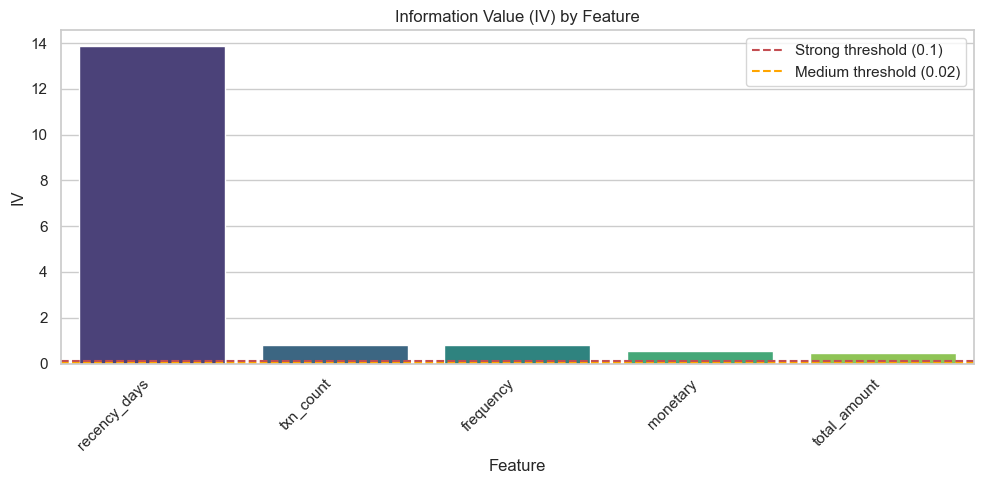

In [ ]:
# Visualize IV
plt.figure(figsize=(10, 5))
sns.barplot(x="feature", y="IV", data=df_iv, palette="viridis", hue="feature", legend=False)
plt.axhline(y=0.1, color="r", linestyle="--", label="Strong threshold (0.1)")
plt.axhline(y=0.02, color="orange", linestyle="--", label="Medium threshold (0.02)")
plt.title("Information Value (IV) by Feature")
plt.xlabel("Feature")
plt.ylabel("IV")
plt.legend()
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
# Show WoE details for top feature
top_feature = df_iv.iloc[0]["feature"]
print(f"WoE Details for '{top_feature}':")
woe_results[top_feature]

WoE Details for 'recency_days':


,bin,bad,total,good,dist_bad,dist_good,woe,iv,total_iv
0,"(0.999, 5.0]",0,873,873,0.000100,0.376943,8.234679,3.103181,13.863098
1,"(5.0, 15.0]",0,649,649,0.000100,0.280225,7.938176,2.223678,13.863098
2,"(15.0, 35.0]",0,747,747,0.000100,0.322539,8.078809,2.604922,13.863098
3,"(35.0, 58.8]",677,724,47,0.474755,0.020294,-3.152492,1.432684,13.863098
4,"(58.8, 91.0]",749,749,0,0.525245,0.000100,-8.566451,4.498633,13.863098


**Observation**: 
- Features with higher IV are more predictive of the target.
- WoE shows the direction and strength of the relationship between feature bins and the target.

## 8. View MLflow Experiments

To view the MLflow UI, run the following command in your terminal:

```bash
mlflow ui --backend-store-uri file:///path/to/Credit-Risk-Probability-Model/mlruns
```

Then open http://localhost:5000 in your browser.

In [ ]:
# Print MLflow run IDs for reference
print("MLflow Run IDs:")
for model_name, data in results.items():
    print(f"  {model_name}: {data['run_id']}")

MLflow Run IDs:
  LogisticRegression: fc5304ac7949407cb901492227ef295a
  DecisionTree: a367f136678648aeb9f8f57d35ca5c1e
  RandomForest: fff0927fc50042afa0295544ece28575
  GradientBoosting: f42196e4e70a42bb86e9c12f4e7ed656


## 9. Summary

### Models Trained

| Model | ROC-AUC | F1 | Accuracy | Precision | Recall |
|-------|---------|----|---------:|----------:|-------:|
| (Results shown in comparison table above) |

### Best Model

The best model based on ROC-AUC is shown above. It has been:
- Tuned with GridSearchCV (5-fold CV).
- Evaluated on the held-out test set.
- Logged to MLflow with all parameters, metrics, and artifacts.
- Registered in the MLflow Model Registry (if available).

### WoE/IV Analysis

We computed Information Value for key features to understand their predictive power for the `is_high_risk` target.

### Next Steps (Task 6)

1. Create a FastAPI REST API to serve the best model.
2. Containerize with Docker.
3. Set up CI/CD with GitHub Actions.